In [1]:
from quests_data import *

import random
import itertools
import seaborn as sns
from scipy import stats
from ase.io import read
from quests.tools.plotting import savefig, COLORS

def clean_filename(name):
    return name.split("/")[-1].strip(".xyz")

In [2]:
def bin_averages(x, y, n, wfactor=1.2, method="mean"):
    centers = np.linspace(x.min(), x.max(), n + 1)
    window = wfactor * (x.max() - x.min()) / (2 * n)
    avgs = []
    for center in centers:
        mask = (x >= center - window) & (x < center + window)
        grp = y[mask]
        if method == "mean":
            avgs.append(grp.mean())
        elif method == "min":
            avgs.append(grp.min())
        elif method == "max":
            avgs.append(grp.max())
    
    return centers, np.array(avgs)

## Loading the precomputed data on dH and evaluated forces

In [3]:
DATA = "../data/02-GAP20/defects-uq"
files = sorted(os.listdir(DATA))

dH = []
for file in files:
    with open(os.path.join(DATA, file), "r") as f:
        data = json.load(f)
    
    data.pop("bandwidth")
    data.pop("root_path")
    data["ref"] = clean_filename(data.pop("reference"))
    data["test"] = clean_filename(data.pop("dset"))
    for delta in data.pop("delta_entropy"):
        dH.append({
            **data,
            "dH": delta,
        })

dH = pd.DataFrame(dH)

In [4]:
DATA = "../data/02-GAP20/defects-eval"
files = sorted(os.listdir(DATA))

ferrs = []
for file in tqdm.tqdm(files):
    name = clean_filename(file)
    dset = read(os.path.join(DATA, file), index=":")
    for i, atoms in enumerate(dset):
        true = atoms.get_forces()
        pred = atoms.arrays["MACE_forces"]
        err = np.linalg.norm(true - pred, axis=1)
        
        for j, e in enumerate(err):
            ferrs.append({
                "dset": name,
                "frame": i,
                "atom": j,
                "err": e,
                "true": np.linalg.norm(true[j]),
                "pred": np.linalg.norm(pred[j]),
            })

ferrs = pd.DataFrame(ferrs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:08<00:00,  2.06it/s]


In [5]:
ferrs

,dset,frame,atom,err,true,pred
0,Amorphous_Bulk,0,0,1.305664,0.893781,1.873382
1,Amorphous_Bulk,0,1,1.958478,3.665796,2.415740
2,Amorphous_Bulk,0,2,1.916481,2.458762,3.609516
3,Amorphous_Bulk,0,3,3.271204,8.222772,7.007020
4,Amorphous_Bulk,0,4,1.545039,5.500652,4.052683
...,...,...,...,...,...,...
1345241,Surfaces,539,95,0.629592,2.499440,1.887420
1345242,Surfaces,539,96,0.234934,5.038040,4.991227
1345243,Surfaces,539,97,0.585190,3.903050,3.915461
1345244,Surfaces,539,98,0.808642,6.636739,5.859444


In [6]:
ferrs["dH"] = dH["dH"]
ferrs["logerr"] = np.log10(ferrs["err"])

/opt/homebrew/Caskroom/miniconda/base/envs/quests/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


## UQ for models trained on the Defects subset

In [7]:
for name, grp in ferrs.groupby("dset"):
    mean_f = grp["pred"].mean()
    print(f"{name}: {mean_f:.1f} eV/Å")

Amorphous_Bulk: 4.4 eV/Å
Amorphous_Surfaces: 3.4 eV/Å
Crystalline_Bulk: 0.8 eV/Å
Crystalline_RSS: 5.1 eV/Å
Defects: 2.7 eV/Å
Diamond: 1.6 eV/Å
Dimer: 62.9 eV/Å
Fullerenes: 5.5 eV/Å
Graphene: 2.8 eV/Å
Graphite: 1.2 eV/Å
Graphite_Layer_Sep: 0.1 eV/Å
LD_Iter1: 5.0 eV/Å
Liquid: 861.4 eV/Å
Liquid_Interface: 5.5 eV/Å
Nanotubes: 2.9 eV/Å
SACADA: 23.0 eV/Å
Single_Atom: 0.0 eV/Å
Surfaces: 169.5 eV/Å


In [8]:
overlaps = {
    "Fullerenes": 22,
    "Graphite": 50,
    "Nanotubes": 75,
    "Graphene": 100,
}

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


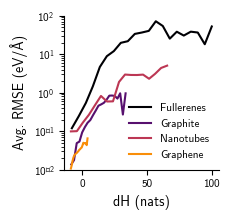

In [9]:
subsets = [
    "Fullerenes",
    "Graphite",
    "Nanotubes",
    "Graphene",
]

fig, ax = plt.subplots(figsize=(2.0, 2.0), sharey=True)

norm = plt.Normalize(25, 125)
cmap = lambda _x: cm.inferno(norm(_x))

for name in subsets:
    subdf = ferrs.loc[ferrs["dset"] == name]
    x = subdf["dH"].clip(upper=100)
    y = subdf["err"].clip(upper=1e4)
    
    bins, ymax = bin_averages(x, y, 20, wfactor=1.5, method="max")
    bins, ymean = bin_averages(x, y, 20, wfactor=1.5, method="mean")
    bins, ymin = bin_averages(x, y, 20, wfactor=1.5, method="min")
    
    ax.plot(bins, ymean, label=name, color=cmap(overlaps[name]))
#     ax.fill_between(bins, ymin, ymax, alpha=0.5)
    ax.set_yscale("log")

ax.set_ylabel("Avg. RMSE (eV/Å)")
ax.set_xlabel("dH (nats)")

ax.set_ylim(1e-2, 1e2)

ax.legend(ncols=1, frameon=False)
# savefig(fig, "05-gap20-uq-rmse.pdf")
plt.show()

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


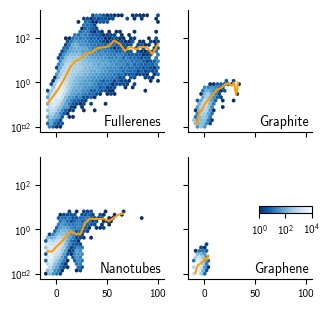

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(3.5, 3.5), sharex=True, sharey=True)

for ax, name in zip(axs.ravel(), subsets):
    subdf = ferrs.loc[ferrs["dset"] == name]
    x = subdf["dH"].clip(upper=100)
    y = subdf["err"]
    
    bins, ymax = bin_averages(x, y, 20, wfactor=1.5, method="max")
    bins, ymean = bin_averages(x, y, 20, wfactor=1.5, method="mean")
    bins, ymin = bin_averages(x, y, 20, wfactor=1.5, method="min")

    hb = ax.hexbin(
        x,
        y,
        gridsize=31,
        mincnt=1,
        bins="log",
        linewidths=(0.,),
        yscale="log",
        extent=(-10, 100, -2, 3),
        vmax=10000,
        vmin=1,
        cmap="Blues_r"
    )
    ax.annotate(
        name,
        (0.98, 0.05),
        xycoords="axes fraction",
        ha="right",
    )

    ax.plot(bins, ymean, label=name, color=cm.inferno(200))

#     ax.plot([0, 0], [y.min(), y.max()], "k--")
#     ax.set_yscale("log")

# cbar = fig.colorbar(hb, ax=axs[-1])

cax = fig.add_axes([0.75, 0.3, 0.15, 0.02])
cbar = fig.colorbar(hb, cax=cax, orientation='horizontal')
cbar.set_ticks([1, 1e2, 1e4])

ax.set_yticks([1e-2, 1e0, 1e2])
# fig.tight_layout()
fig.subplots_adjust(wspace=0.2)
# savefig(fig, "05-gap20-uq-scatter.pdf")
plt.show()

## Conformal prediction

In [11]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

def calibrate_conformal(data, quantile=0.50):
    """
    Calibrate a map between dH and error using quantile regression as commonly employed
    in conformal prediction.
    
    Parameters
    ----------
    data : pd.DataFrame
        A DataFrame containing two columns: 'error' and 'dH'.
    quantile : float, optional
        The quantile level for the regression. For example, 0.95 corresponds to the 95th percentile
        quantile regression line.
        
    Returns
    -------
    predict_fn : callable
        A function that, given new values of dH, returns the predicted error quantile.
    model : statsmodels.regression.linear_model.RegressionResults
        The fitted quantile regression model object.
    """
    # Ensure the required columns exist
    if 'err' not in data.columns or 'dH' not in data.columns:
        raise ValueError("DataFrame must contain 'err' and 'dH' columns.")
    
    # Fit a quantile regression model: error ~ dH
    # We can use a simple linear specification as a starting point.
    # For more complex relationships, consider transformations or polynomial terms.
    model = smf.quantreg('logerr ~ dH', data).fit(q=quantile)
    
    # Define a prediction function
    def predict_fn(dH_values):
        """
        Given an array or scalar of dH values, return the predicted error quantile.
        """
        # Convert input to a DataFrame for the model
        if np.isscalar(dH_values):
            dH_values = np.array([dH_values])
        pred_data = pd.DataFrame({'dH': dH_values})
        return model.predict(pred_data)
    
    return predict_fn, model

def predict_errors(subdf, quantile=0.5):
    train = random.sample(list(subdf.index), len(subdf) // 2)
    test = list(set(range(len(subdf))) - set(train))
    _qt, model = calibrate_conformal(subdf.loc[train], quantile=quantile)
    predlogerr = _qt(subdf.loc[test]["dH"])
    prederr = np.power(10, predlogerr)
    trueerr = subdf.loc[test]["err"].values
    return trueerr, prederr

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


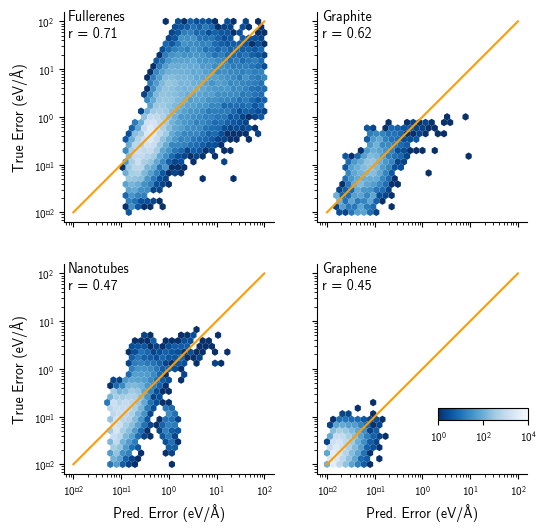

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)

lims = [1e-2, 1e2]

subsets = [
    "Fullerenes",
    "Graphite",
    "Nanotubes",
    "Graphene",
]

for ax, name in zip(axs.ravel(), subsets):
    subdf = ferrs.loc[ferrs["dset"] == name].reset_index(drop=True)
    y, x = predict_errors(subdf, quantile=0.5)

    hb = ax.hexbin(
        x,
        y,
        gridsize=31,
        mincnt=1,
        bins="log",
        linewidths=(0.,),
        yscale="log",
        xscale="log",
        extent=(-2, 2, -2, 2),
        vmax=10000,
        vmin=1,
        cmap="Blues_r"
    )

    ax.plot(lims, lims, color=cm.inferno(200))
    ax.set_aspect("equal")

    r = stats.pearsonr(np.log(x), np.log(y))
    # r = stats.pearsonr(x, y)
    ax.annotate(name, (0.02, 0.98), xycoords="axes fraction", ha="left", va="center")
    ax.annotate(f"r = {r.statistic:0.2f}", (0.02, 0.90), xycoords="axes fraction", ha="left", va="center")

#     ax.plot([0, 0], [y.min(), y.max()], "k--")
#     ax.set_yscale("log")

# cbar = fig.colorbar(hb, ax=axs[-1])

cax = fig.add_axes([0.75, 0.2, 0.15, 0.02])
cbar = fig.colorbar(hb, cax=cax, orientation='horizontal')
cbar.set_ticks([1, 1e2, 1e4])


for ax in axs[-1, :]:
    ax.set_xlabel("Pred. Error (eV/Å)")

for ax in axs[:, 0]:
    ax.set_ylabel("True Error (eV/Å)")
    
# ax.set_yticks([1e-2, 1e0, 1e2])
# fig.tight_layout()
fig.subplots_adjust(wspace=0.2)
# savefig(fig, "05-gap20-uq-ConfPred.pdf")
plt.show()

## Distributions of errors for the model trained on the Defects usbset

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

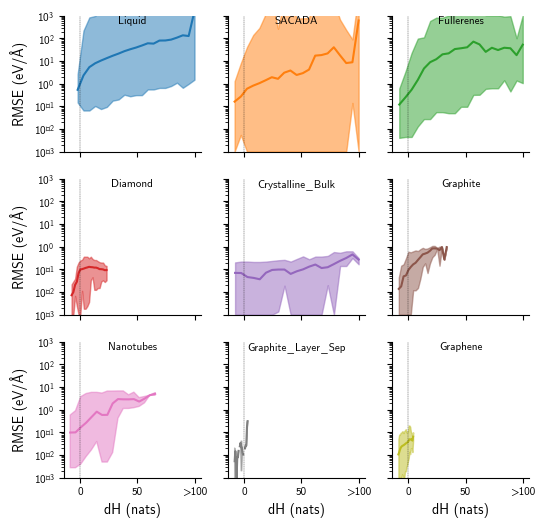

In [13]:
subsets = [
    "Liquid",
    "SACADA",
    "Fullerenes",
    "Diamond",
    "Crystalline_Bulk",
    "Graphite",
    "Nanotubes",
    "Graphite_Layer_Sep",
    "Graphene",
]

fig, axs = plt.subplots(3, 3, figsize=(6.0, 6.0), sharey=True, sharex=True)

norm = plt.Normalize(25, 125)
cmap = lambda _x: cm.inferno(norm(_x))

for i, (name, ax) in enumerate(zip(subsets, axs.ravel())):
    subdf = ferrs.loc[ferrs["dset"] == name]
    mean_f = subdf["true"].mean()
    
    color = cm.tab10(i) #cmap(overlaps[name])
    x = subdf["dH"].clip(upper=100)
    y = (subdf["err"]).clip(lower=1e-3, upper=1e4)
    
    bins, ymax = bin_averages(x, y, 20, wfactor=1.5, method="max")
    bins, ymean = bin_averages(x, y, 20, wfactor=1.5, method="mean")
    bins, ymin = bin_averages(x, y, 20, wfactor=1.5, method="min")

    ax.plot(bins, ymean, label=name, color=color)
    ax.fill_between(bins, ymin, ymax, alpha=0.5, color=color)
    ax.plot([0, 0], [1e-3, 1e3], "k--", linewidth=0.25)
    ax.set_yscale("log")
    ax.annotate(
        name,
        (0.5, 1.0),
        xycoords="axes fraction",
        ha="center",
        va="top",
        fontsize=8
    )

for ax in axs[:, 0]:
    ax.set_ylabel("RMSE (eV/Å)")

for ax in axs[-1, :]:
    ax.set_xlabel("dH (nats)")
    ax.set_xticks([0, 50, 100])
    ax.set_xticklabels([0, 50, ">100"])

ax.set_ylim(1e-3, 1e3)

# ax.legend(ncols=1, frameon=False)
# savefig(fig, "05-uq-defects-dH.pdf")
plt.show()